In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
length_x = 1
length_y = 1

In [3]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [4]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [5]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [6]:
max_wave = 5
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [7]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [8]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [9]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [10]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

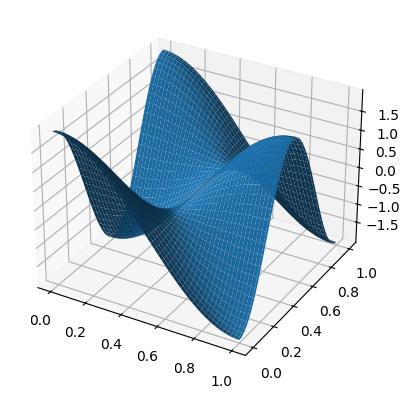

In [11]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,2)])

In [54]:
my_mean = np.array([0.7,0.7])
my_cov = np.array([[0.01,0],[0,0.002]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [55]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij

In [83]:
# optional overwrite with uniform
my_pdf = np.ones_like(x_grid)/x_grid.size

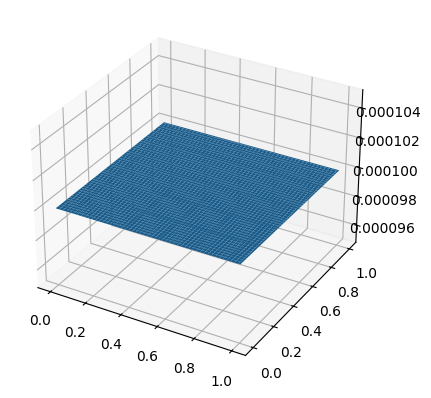

In [84]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [85]:
inner_product(my_pdf,basis[(0,0)])

0.00010000000000000005

In [86]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [87]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

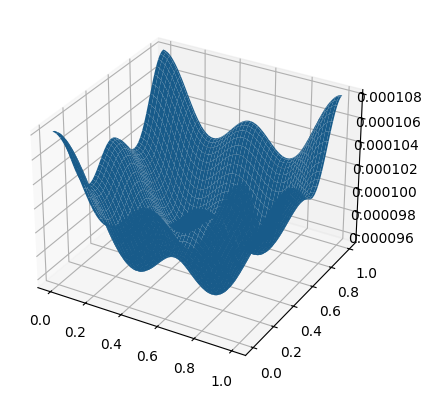

In [88]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [89]:
wp_num_x = 5
wp_num_y = 5
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))

In [90]:
num_wp = wp_num_x*wp_num_y

In [91]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

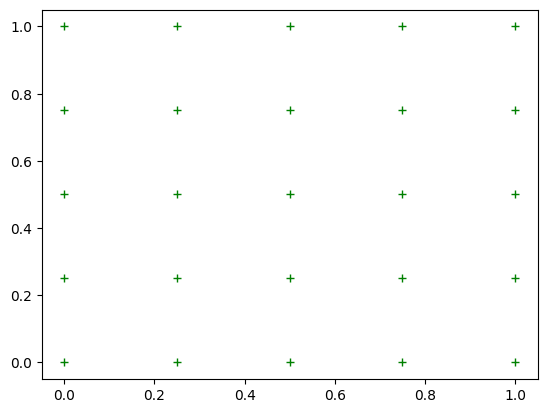

In [92]:
plt.plot(x_wp,y_wp,'g+')

In [93]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]

In [94]:
links

[(0, 1),
 (0, 5),
 (1, 0),
 (1, 2),
 (1, 6),
 (2, 1),
 (2, 3),
 (2, 7),
 (3, 2),
 (3, 4),
 (3, 8),
 (4, 3),
 (4, 9),
 (5, 0),
 (5, 6),
 (5, 10),
 (6, 1),
 (6, 5),
 (6, 7),
 (6, 11),
 (7, 2),
 (7, 6),
 (7, 8),
 (7, 12),
 (8, 3),
 (8, 7),
 (8, 9),
 (8, 13),
 (9, 4),
 (9, 8),
 (9, 14),
 (10, 5),
 (10, 11),
 (10, 15),
 (11, 6),
 (11, 10),
 (11, 12),
 (11, 16),
 (12, 7),
 (12, 11),
 (12, 13),
 (12, 17),
 (13, 8),
 (13, 12),
 (13, 14),
 (13, 18),
 (14, 9),
 (14, 13),
 (14, 19),
 (15, 10),
 (15, 16),
 (15, 20),
 (16, 11),
 (16, 15),
 (16, 17),
 (16, 21),
 (17, 12),
 (17, 16),
 (17, 18),
 (17, 22),
 (18, 13),
 (18, 17),
 (18, 19),
 (18, 23),
 (19, 14),
 (19, 18),
 (19, 24),
 (20, 15),
 (20, 21),
 (21, 16),
 (21, 20),
 (21, 22),
 (22, 17),
 (22, 21),
 (22, 23),
 (23, 18),
 (23, 22),
 (23, 24),
 (24, 19),
 (24, 23)]

In [95]:
import pulp

In [96]:
prob = pulp.LpProblem('ergo')

In [97]:
x = pulp.LpVariable.dicts("x",links,0,1,pulp.LpInteger)

In [98]:
# continuity - must leave everywhere we go
for w in range(wp_num_x*wp_num_y):
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) == sum(sum([x[i,j] for (i,j) in links if j==w])))

In [99]:
# can't go anywhere twice - would be nice to omit this, but then how to include subtours?
for w in range(wp_num_x*wp_num_y):
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) <= 1)

In [100]:
num_moves = 10
prob.addConstraint(sum([x[lk] for lk in links])==num_moves)

In [101]:
f_traj = {}
for (i,j) in links:
    sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
    for k in wave_numbers:
        f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [102]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [103]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [104]:
for k in wave_numbers:
    prob.addConstraint(s[k] >= lam[k]*(eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links])/num_moves))
    prob.addConstraint(s[k] >= -lam[k]*(eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links])/num_moves))

In [105]:
prob.setObjective(sum([s[k] for k in wave_numbers]))

In [106]:
prob

ergo:
MINIMIZE
1*s_(0,_0) + 1*s_(0,_1) + 1*s_(0,_2) + 1*s_(0,_3) + 1*s_(0,_4) + 1*s_(1,_0) + 1*s_(1,_1) + 1*s_(1,_2) + 1*s_(1,_3) + 1*s_(1,_4) + 1*s_(2,_0) + 1*s_(2,_1) + 1*s_(2,_2) + 1*s_(2,_3) + 1*s_(2,_4) + 1*s_(3,_0) + 1*s_(3,_1) + 1*s_(3,_2) + 1*s_(3,_3) + 1*s_(3,_4) + 1*s_(4,_0) + 1*s_(4,_1) + 1*s_(4,_2) + 1*s_(4,_3) + 1*s_(4,_4) + 0
SUBJECT TO
_C1: x_(0,_1) + x_(0,_5) - x_(1,_0) - x_(5,_0) = 0

_C2: - x_(0,_1) + x_(1,_0) + x_(1,_2) + x_(1,_6) - x_(2,_1) - x_(6,_1) = 0

_C3: - x_(1,_2) + x_(2,_1) + x_(2,_3) + x_(2,_7) - x_(3,_2) - x_(7,_2) = 0

_C4: - x_(2,_3) + x_(3,_2) + x_(3,_4) + x_(3,_8) - x_(4,_3) - x_(8,_3) = 0

_C5: - x_(3,_4) + x_(4,_3) + x_(4,_9) - x_(9,_4) = 0

_C6: - x_(0,_5) - x_(10,_5) + x_(5,_0) + x_(5,_10) + x_(5,_6) - x_(6,_5) = 0

_C7: - x_(1,_6) - x_(11,_6) - x_(5,_6) + x_(6,_1) + x_(6,_11) + x_(6,_5)
 + x_(6,_7) - x_(7,_6) = 0

_C8: - x_(12,_7) - x_(2,_7) - x_(6,_7) + x_(7,_12) + x_(7,_2) + x_(7,_6)
 + x_(7,_8) - x_(8,_7) = 0

_C9: - x_(13,_8) - x_(3,_8) - x_(

In [107]:
prob.solve()
print(pulp.LpStatus[prob.status])

Optimal


In [108]:
moves = [(i,j) for (i,j) in links if x[i,j].value()==1]
moves

[(3, 8),
 (5, 6),
 (6, 5),
 (8, 3),
 (12, 13),
 (13, 12),
 (15, 16),
 (16, 15),
 (18, 23),
 (23, 18)]

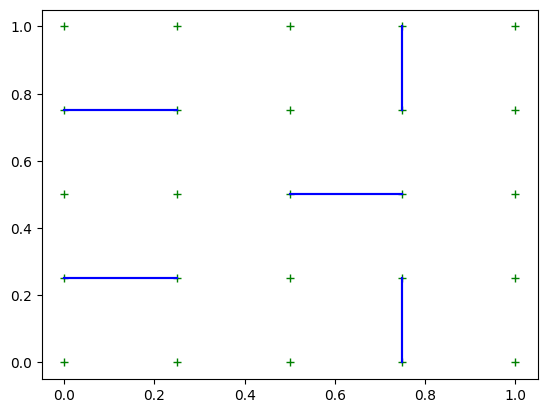

In [109]:
plt.plot(x_wp,y_wp,'g+')
for (i,j) in moves:
    plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'b-')